In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
import pathlib
import os
import tensorflow_hub as hub
from PIL import Image
from PIL import ImageOps
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
!pip install tensorflow==2.3.1


In [ ]:
print(tf.version.VERSION)

2.3.1


In [ ]:
training_data = tf.keras.utils.get_file(fname='Training', origin='https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip', extract=True, archive_format='zip', cache_dir='data')
validation_data = tf.keras.utils.get_file(fname='Validation', origin='https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip', extract=True, archive_format='zip', cache_dir='data')
testing_data = tf.keras.utils.get_file(fname='Testing', origin='https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip', extract=True, archive_format='zip', cache_dir='data')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
training_data = pathlib.Path('/content/drive/MyDrive/CancerDatasets/datasets/train')
testing_data = pathlib.Path('/content/drive/MyDrive/CancerDatasets/datasets/test')
validation_data = pathlib.Path('/content/drive/MyDrive/CancerDatasets/datasets/valid')

In [ ]:
train_image_count = len(list(training_data.glob('*/*.jpg')))
print(train_image_count)

2000


In [ ]:
val_image_count = len(list(validation_data.glob('*/*.jpg')))
print(val_image_count)

150


In [ ]:
test_image_count = len(list(testing_data.glob('*/*.jpg')))
print(test_image_count)

600


## Writing Input Pipeline

In [ ]:
class_names = np.array(sorted(image.stem for image in training_data.glob('*')))
class_names

array(['melanoma', 'nevus', 'seborrheic_keratosis'], dtype='<U20')

In [ ]:
def get_label(file_path):
    path = tf.strings.split(file_path, '/')
    label = path[-2]
    y = label == class_names
    return y

In [ ]:
def get_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [256,256])

In [ ]:
def get_pair(file_path):
    return get_image(file_path), get_label(file_path)

In [ ]:
train_ds = [str(img) for img in training_data.glob("*/*.jpg")]
valid_ds = [str(img) for img in validation_data.glob("*/*.jpg")]
test_ds = [str(img) for img in testing_data.glob("*/*.jpg")]

In [ ]:
# Stratified Subsampling

def create_dataset(path_list, per=0.1):
    y = [np.int(get_label(img)) for img in path_list]
    unselected_x, selected_x, unselected_y, selected_y = train_test_split(path_list, y, shuffle=True, test_size=per, stratify=y)
    return selected_x

In [ ]:
def gen_pair(path_list):
    for path in path_list:
        yield get_pair(path)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)
valid_ds = tf.data.Dataset.from_tensor_slices(valid_ds)
test_ds = tf.data.Dataset.from_tensor_slices(test_ds)

In [ ]:
train_ds = train_ds.map(get_pair)
valid_ds = valid_ds.map(get_pair)
test_ds = test_ds.map(get_pair)

In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=2000)
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=1)
    return ds

In [ ]:
train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)
test_ds = configure_for_performance(test_ds)

In [ ]:
test_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 3), dtype=tf.bool, name=None))

In [ ]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy())
        plt.axis("off")

## Building Model

In [ ]:
class_names

array(['melanoma', 'nevus', 'seborrheic_keratosis'], dtype='<U20')

In [ ]:
preprocessing_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256,256,3))

In [ ]:
#---Testing CNN Model

model = tf.keras.Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(256,256,3)),
    layers.MaxPool2D(5,5,'same'),
    layers.Conv2D(64,5,padding='same',activation='relu'),
    layers.MaxPool2D(5,5,'same'),
    layers.Conv2D(126,5,padding='same',activation='relu'),
    layers.MaxPool2D(5,5,'same'),
    layers.Flatten(),
    layers.Dense(500,'relu'),
    layers.Dropout(0.5),
    layers.Dense(25,'relu'),
    layers.Dense(3)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 51, 51, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 126)       201726    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 126)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1134)              0

In [ ]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
checkpoint_path = '/content/drive/MyDrive/checkpoints/cp_ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 mode='max',
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_ds, validation_data=valid_ds,epochs=20,callbacks=[cp_callback])

In [ ]:
model.save('/content/drive/MyDrive/checkpoints/cp_ckpt')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoints/cp_ckpt4/assets


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/checkpoints/cp_ckpt')

In [ ]:
acc, loss = model.evaluate(test_ds, verbose=2)

19/19 - 9s - loss: 0.7408 - accuracy: 0.6800


## Data Augmentation

In [ ]:
img, label = next(iter(train_ds))

In [ ]:
data_augmentation = tf.keras.Sequential([
      preprocessing.Rescaling(1./255),
      preprocessing.RandomFlip("horizontal_and_vertical"),
      preprocessing.RandomRotation(0.2),
])

In [ ]:
img = img[3]
label = label[3]

img = tf.expand_dims(img, 0)

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = data_augmentation(img)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0].numpy())
  plt.axis("off")

In [ ]:
model = tf.keras.Sequential([
          data_augmentation,
          model
])

In [ ]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
checkpoint_path = '/content/drive/MyDrive/checkpoints/cp_ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 mode='max',
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_ds, validation_data=valid_ds,epochs=20,callbacks=[cp_callback])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,10))
epoch_range = range(20)
plt.subplot(1,2,1)
plt.plot(epoch_range, acc, label="Training Accuracy")
plt.plot(epoch_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epoch_range, loss, label="Training Loss")
plt.plot(epoch_range, val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.show()

## Transfer Learning

### Training Model for Seborrheic Keratosis

In [ ]:
class_names

array(['melanoma', 'nevus', 'seborrheic_keratosis'], dtype='<U20')

In [ ]:
def sk_get_label(file_path):
    path = tf.strings.split(file_path, '/')
    label = path[-2]
    
    if label == 'melanoma' or label == 'nevus':
      return 0
    else:
      return 1

In [ ]:
def get_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [256,256])

In [ ]:
def sk_get_pair(file_path):
    return get_image(file_path), sk_get_label(file_path)

In [ ]:
sk_train_ds = [str(img) for img in training_data.glob("*/*.jpg")]
sk_valid_ds = [str(img) for img in validation_data.glob("*/*.jpg")]
sk_test_ds  = [str(img) for img in testing_data.glob("*/*.jpg")]

In [ ]:
sk_train_ds = tf.data.Dataset.from_tensor_slices(sk_train_ds)
sk_valid_ds = tf.data.Dataset.from_tensor_slices(sk_valid_ds)
sk_test_ds = tf.data.Dataset.from_tensor_slices(sk_test_ds)

In [ ]:
sk_train_ds = sk_train_ds.map(sk_get_pair)
sk_valid_ds = sk_valid_ds.map(sk_get_pair)
sk_test_ds = sk_test_ds.map(sk_get_pair)

In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=2000)
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=1)
    return ds

In [ ]:
sk_train_ds = configure_for_performance(sk_train_ds)
sk_valid_ds = configure_for_performance(sk_valid_ds)
sk_test_ds = configure_for_performance(sk_test_ds)

In [ ]:
# Model taken from https://arxiv.org/ftp/arxiv/papers/1703/1703.03108.pdf
# Model used for Transfer Learning A. Kolesnikov, L. Beyer, X. Zhai, J. Puigcerver, J. Yung, S. Gelly and N. Houlsby: Big Transfer (BiT): General Visual Representation Learning.

IMAGE_SHAPE = (256,256,3)
classifier_model = 'https://tfhub.dev/google/bit/m-r50x1/1'

classifier = tf.keras.Sequential([
          hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
      preprocessing.Rescaling(1./255),
      preprocessing.RandomFlip("horizontal_and_vertical"),
      preprocessing.RandomRotation(0.2),
])

In [ ]:
# Creating Ensemble Model

inputs = tf.keras.Input(shape=(256,256,3))
transformation1 = data_augmentation(inputs)
transformation2 = data_augmentation(inputs)
transformation3 = data_augmentation(inputs)

feature_set1 = classifier(inputs, training=False)
feature_set1 = layers.Dropout(0.5)(feature_set1)

feature_set2 = classifier(transformation1, training=False)
feature_set2 = layers.Dropout(0.5)(feature_set2)

feature_set3 = classifier(transformation2, training=False)
feature_set3 = layers.Dropout(0.5)(feature_set3)

feature_set4 = classifier(transformation3, training=False)
feature_set4 = layers.Dropout(0.5)(feature_set4)

x = layers.concatenate([feature_set1, feature_set2, feature_set3, feature_set4])
output = layers.Dense(1, activation='sigmoid')(x)

seborrheic_model = tf.keras.Model(inputs, output)

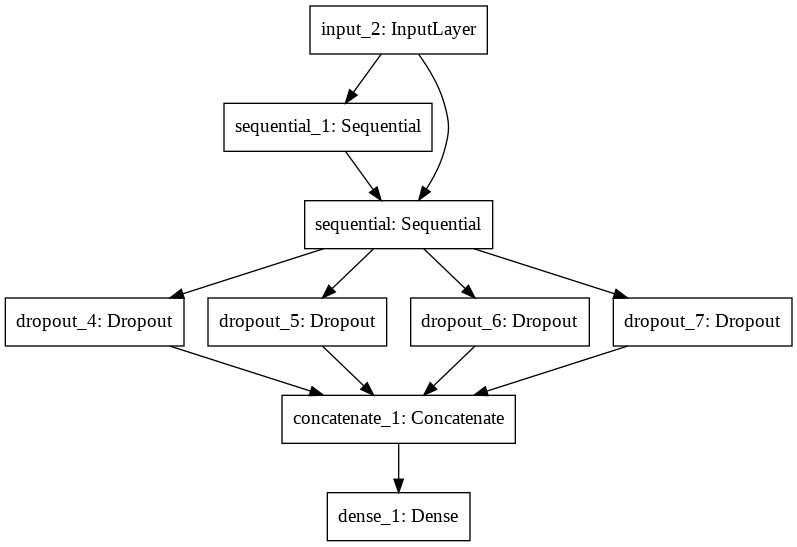

In [ ]:
tf.keras.utils.plot_model(seborrheic_model)

In [ ]:
seborrheic_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])

In [ ]:
sk_train_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
history = seborrheic_model.fit(sk_train_ds, validation_data=sk_valid_ds, epochs=20)

In [ ]:
seborrheic_model.save('/content/drive/MyDrive/checkpoints')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoints/assets


In [ ]:
seborrheic_model = tf.keras.models.load_model('/content/drive/MyDrive/checkpoints')

In [ ]:
loss, acc = seborrheic_model.evaluate(sk_test_ds, verbose=2)

19/19 - 16s - loss: 0.6333 - auc_1: 0.7969


In [ ]:
print(f"The testing loss is {loss} and the testing accuracy is {acc}")

The testing loss is 0.6333078145980835 and the testing accuracy is 0.7968626618385315


## Model for Melanoma

In [ ]:
class_names

array(['melanoma', 'nevus', 'seborrheic_keratosis'], dtype='<U20')

In [ ]:
def m_get_label(file_path):
    path = tf.strings.split(file_path, '/')
    label = path[-2]
    
    if label == 'nevus' or label == 'seborrheic_keratosis':
      return 0
    else:
      return 1

In [ ]:
def get_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [256,256])

In [ ]:
def m_get_pair(file_path):
    return get_image(file_path), m_get_label(file_path)

In [ ]:
m_train_ds = [str(img) for img in training_data.glob("*/*.jpg")]
m_valid_ds = [str(img) for img in validation_data.glob("*/*.jpg")]
m_test_ds  = [str(img) for img in testing_data.glob("*/*.jpg")]

In [ ]:
m_train_ds = tf.data.Dataset.from_tensor_slices(m_train_ds)
m_valid_ds = tf.data.Dataset.from_tensor_slices(m_valid_ds)
m_test_ds = tf.data.Dataset.from_tensor_slices(m_test_ds)

In [ ]:
m_train_ds = m_train_ds.map(m_get_pair)
m_valid_ds = m_valid_ds.map(m_get_pair)
m_test_ds =  m_test_ds.map(m_get_pair)

In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=2000)
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=1)
    return ds

In [ ]:
m_train_ds = configure_for_performance(m_train_ds)
m_valid_ds = configure_for_performance(m_valid_ds)
m_test_ds =  configure_for_performance(m_test_ds)

In [ ]:
# Model taken from https://arxiv.org/ftp/arxiv/papers/1703/1703.03108.pdf
# Model used for Transfer Learning A. Kolesnikov, L. Beyer, X. Zhai, J. Puigcerver, J. Yung, S. Gelly and N. Houlsby: Big Transfer (BiT): General Visual Representation Learning.

IMAGE_SHAPE = (256,256,3)
classifier_model = 'https://tfhub.dev/google/bit/m-r50x1/1'

classifier = tf.keras.Sequential([
          hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
      preprocessing.Rescaling(1./255),
      preprocessing.RandomFlip("horizontal_and_vertical"),
      preprocessing.RandomRotation(0.2),
])

In [ ]:
# Creating Ensemble Model

inputs = tf.keras.Input(shape=(256,256,3))
transformation1 = data_augmentation(inputs)
transformation2 = data_augmentation(inputs)
transformation3 = data_augmentation(inputs)

feature_set1 = classifier(inputs, training=False)
feature_set1 = layers.Dropout(0.5)(feature_set1)

feature_set2 = classifier(transformation1, training=False)
feature_set2 = layers.Dropout(0.5)(feature_set2)

feature_set3 = classifier(transformation2, training=False)
feature_set3 = layers.Dropout(0.5)(feature_set3)

feature_set4 = classifier(transformation3, training=False)
feature_set4 = layers.Dropout(0.5)(feature_set4)

x = layers.concatenate([feature_set1, feature_set2, feature_set3, feature_set4])
output = layers.Dense(1, activation='sigmoid')(x)

melanoma_model = tf.keras.Model(inputs, output)

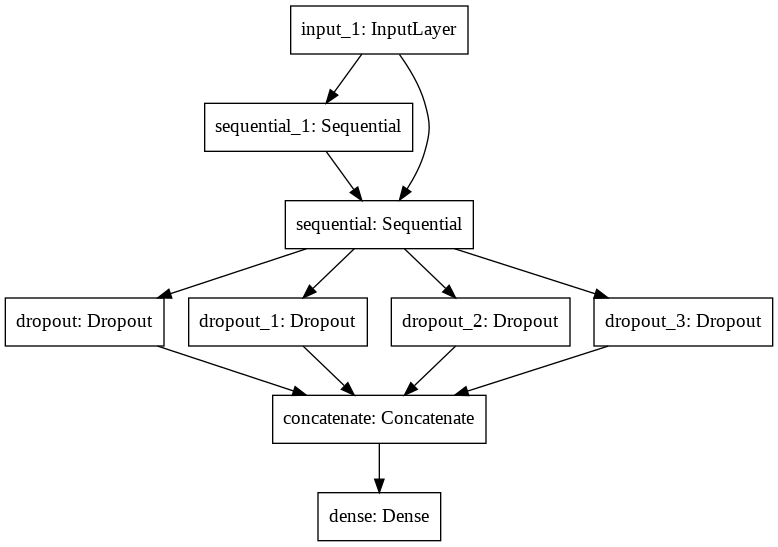

In [ ]:
tf.keras.utils.plot_model(melanoma_model)

In [ ]:
melanoma_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])

In [ ]:
m_train_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
history = melanoma_model.fit(m_train_ds, validation_data=m_valid_ds, epochs=20)

In [ ]:
melanoma_model.save('/content/drive/MyDrive/checkpoints/assets_nv')

In [ ]:
melanoma_model = tf.keras.models.load_model('/content/drive/MyDrive/checkpoints/assets_nv')

In [ ]:
loss, acc = melanoma_model.evaluate(m_test_ds, verbose=2)

## Combining the Models

In [ ]:
melanoma_model = tf.keras.models.load_model('/content/drive/MyDrive/checkpoints/assets_nv')
seborrheic_model = tf.keras.models.load_model('/content/drive/MyDrive/checkpoints')

In [ ]:
inputs = tf.keras.Input([256,256,3])

m_prediction = melanoma_model(inputs)
sk_prediction = seborrheic_model(inputs)

x = layers.concatenate([m_prediction, tf.ones_like(m_prediction)-m_prediction-sk_prediction, sk_prediction])
output = layers.Activation('softmax')(x)

model = tf.keras.Model(inputs, output)

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1)            23508545    input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           functional_1[0][0]               
__________________________________________________________________________________________________
tf_op_layer_Fill (TensorFlowOpL [(None, 1)]          0           tf_op_layer_Shape[0][0]          
_______________________________________________________________________________________

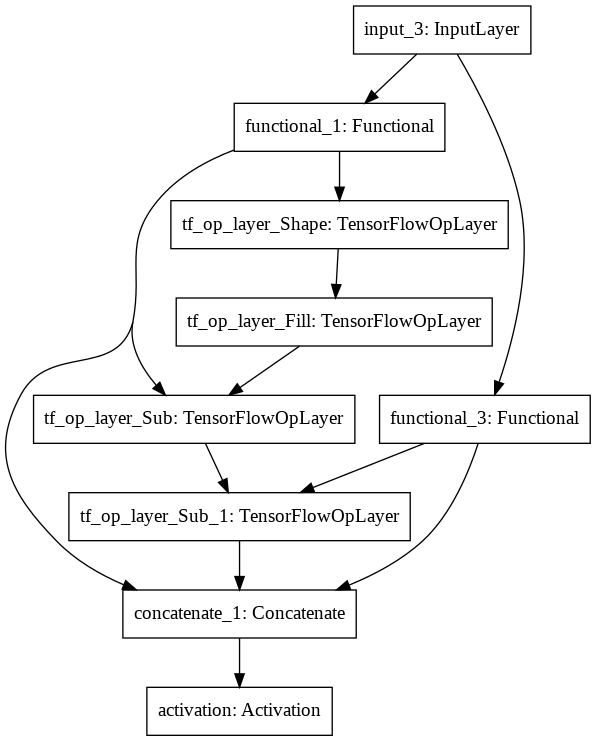

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(
    tf.keras.optimizers.Adam(),
    tf.keras.losses.CategoricalCrossentropy(),
    tf.keras.metrics.AUC()
)

In [ ]:
acc, loss = model.evaluate(test_ds, verbose=2)

19/19 - 46s - loss: 0.8752 - auc_4: 0.8041


In [ ]:
model.save('/content/drive/MyDrive/checkpoints/cancer_prediction')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoints/cancer_prediction/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoints/cancer_prediction/assets
